In [1]:
from rutas import data_clean
maestro = data_clean()
maestro = maestro[(maestro["min"].apply(lambda x: x[:4])=="2022")|(maestro["min"].apply(lambda x: x[:4])=="2021")]

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore")

y = np.array(maestro["calif"])
X = maestro.copy()
X.drop(["calificacion", "calif"], axis=1, inplace=True)

X = X[["COLOR", "ESTETICA", "LARGO", "SILUETA"]]

categorical_columns = maestro.select_dtypes(include='object').columns
df_copy = maestro.copy()
label_encoders = {col: LabelEncoder() for col in categorical_columns}
for col in categorical_columns:
    df_copy[col] = label_encoders[col].fit_transform(df_copy[col])
features = df_copy[["COLOR", "ESTETICA", "LARGO", "SILUETA", "SUBCATEGORIA"]]
target = df_copy['calif']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=1)


<h2 style="text-align:center;">Regresion lineal multivariada</h2>

In [126]:
dict_criterios = {"HOMBRE":
    {"BUZO":["COLOR", "ESTIICA", "TIPO"], #TIPO PULLOVER - HOODIE
    "CAMISA": ["ESTETICA", "FIT", "COLOR"],
    "CAMISETA":["COLOR", "ESTETICA", "FIT", "TIPO"], #TIPO MANGA CORGA - MANGA LARGA
    "CHAQUETA": ["COLOR", "ESTETICA"],
    "JEAN": ["COLOR", "ESTETICA"],
    "JOGGER": ["COLOR", "ESTETICA"],
    "SHORTS": ["COLOR", "ESTETICA"],
    "SHORTS PLANO": ["COLOR", "ESTETICA"],
    "PANTALON": ["COLOR"],
    "POLO": ["COLOR", "TEJIDO", "PUNTO CORAZON"],
    "TANK": ["COLOR", "ESTETICA", "TIPO"] #TIPO CHOMPA
    },
    "MUJER":{"BUZO":["COLOR", "ESTIICA", "TIPO", "LARGO", "BASE TELA", "SILUETA"], #TIPO PULLOVER - HOODIE ## VALIDAR SI TENEMOS SOLUETA
    "CAMISA": ["ESTETICA", "TIPO", "COLOR", "LARGO"], #TIPO MANGA CORGA - MANGA LARGA
    "CAMISETA":["COLOR", "ESTETICA", "LARGO", "SILUETA"], #TIPO MANGA CORGA - MANGA LARGA
    "CHAQUETA": ["COLOR", "ESTETICA", "TIPO", "LARGO", "BASE TELA", "SILUETA"],
    "FALDA": ["ESTETICA", "BASE TELA", "LARGO"],
    "HAREM" : ["SILUETA", "MOLDE", "COLOR", "ESTETICA", "BASE TELA"],
    "JEAN": ["COLOR", "ESTETICA", "TIPO", "TIRO"], #TIRO EN LA SUBCATEGORIA
    "JOGGER": ["COLOR", "ESTETICA", "SILUETA", "BASE TELA", "TIPO"],
    "PANTALON": ["COLOR", "ESTETICA", "TIRO", "TIPO"], #TIRO EN LA SUBCATEGORIA
    "R DEPORTIVA": ["COLOR", "ESTETICA", "BASE TELA", "SILUETA"],
    "SHORTS": ["COLOR", "ESTETICA", "SILUETA", "BASE TELA"],
    "SHORTS DENIM": ["COLOR", "ESTETICA", "BASE TELA", "TIRO"],
    "TOP": ["COLOR", "LARGO", "SILUETA", "ESTETICA", "TIPO"],
    "TOP ML": ["COLOR", "LARGO", "SILUETA", "ESTETICA", "TIPO"],
    "VESTIDO": ["BASE TELA", "SILUETA", "LARGO", "ESTETICA", "COLOR", "TIPO"], 
    "VESTIDO DE BAÑO": ["COLOR", "ESTETICA", "MOLDE"]
    }
}

<h4 style="text-align:center;">Modelo</h4>

In [41]:
for i in range(1000):
    try:
        (X_train, X_test, y_train, y_test) = train_test_split(
            X,
            y,
            train_size = 0.7)
        pipeline = Pipeline(
                steps=[
                    (
                        "column_transformer",
                        make_column_transformer(
                            (
                                OneHotEncoder(),
                                make_column_selector(dtype_include=object)
                            ), 
                            remainder = "passthrough"
                        ),
                    ),
                    (
                        "selectKBest",
                        SelectKBest(score_func=f_regression),
                    ),
                    (
                        "linearRegression",
                        LinearRegression(),
                    ),
                ],
            )
        param_grid = {
                "selectKBest__k": range(1, len(X.columns)),
            }
        gridSearchCV = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                scoring="neg_mean_squared_error",
                refit=True,
                return_train_score=False,
            )
        gridSearchCV.fit(X_train, y_train)
        y_train_pred = gridSearchCV.predict(X_train)
        y_test_pred = gridSearchCV.predict(X_test)
        mse_train = mean_squared_error(
            y_train_pred,
            y_train,
        ).round(2)
        mse_test = mean_squared_error(
            y_test_pred,
            y_test,
        ).round(2)

        r_2 = r2_score(y_pred = y_test_pred, y_true = y_test)

        print(f"mse train: {mse_train} \nmse tres: {mse_test} \nEl R2 es {r_2}")
        break
    except: continue 
print(i)

mse train: 1.5 
mse tres: 1.73 
El R2 es -0.07744033056851274
2


<h2 style="text-align:center;">Red Neuronal TensorFlow</h2>

In [32]:
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Softmax, Dropout
from keras.metrics import CategoricalCrossentropy, Recall
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.initializers import RandomNormal
from keras import optimizers

X_val, X_test_2, y_val, y_test_2 = train_test_split(X_test, y_test, test_size=0.33, random_state=2)
# Crear un modelo de redes neuronales con Keras
model = Sequential()

# Añadir una capa de entrada con la misma cantidad de neuronas que de características
model.add(Dense(features.shape[1], input_dim=features.shape[1], activation='relu', kernel_initializer=RandomNormal(stddev=0.01)))

# Añadir una capa oculta con 16 neuronas
model.add(Dense(24, activation='relu'))
model.add(Dense(48, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(24, activation='relu'))

# Añadir una capa de salida con una sola neurona
model.add(Dense(5, activation='Softmax'))

In [33]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 5)                 30        
                                                                 
 dense_55 (Dense)            (None, 24)                144       
                                                                 
 dense_56 (Dense)            (None, 48)                1200      
                                                                 
 dense_57 (Dense)            (None, 96)                4704      
                                                                 
 dense_58 (Dense)            (None, 128)               12416     
                                                                 
 dense_59 (Dense)            (None, 256)               33024     
                                                                 
 dense_60 (Dense)            (None, 256)              

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
            optimizer='adam',
            metrics = ["sparse_categorical_accuracy", "accuracy"],
            )
history = model.fit(X_train, 
                y_train,   
                epochs=500,
                batch_size=48,
                validation_data = (X_val, y_val)
                )

Epoch 1/500
15/15 [==============================] - 1s 21ms/step - loss: 1.4902 - sparse_categorical_accuracy: 0.3201 - accuracy: 0.3201 - val_loss: 1.4929 - val_sparse_categorical_accuracy: 0.3262 - val_accuracy: 0.3262
Epoch 2/500
15/15 [==============================] - 0s 5ms/step - loss: 1.4485 - sparse_categorical_accuracy: 0.3272 - accuracy: 0.3272 - val_loss: 1.4937 - val_sparse_categorical_accuracy: 0.3090 - val_accuracy: 0.3090
Epoch 3/500
15/15 [==============================] - 0s 6ms/step - loss: 1.4388 - sparse_categorical_accuracy: 0.3031 - accuracy: 0.3031 - val_loss: 1.4754 - val_sparse_categorical_accuracy: 0.3090 - val_accuracy: 0.3090
Epoch 4/500
15/15 [==============================] - 0s 6ms/step - loss: 1.4380 - sparse_categorical_accuracy: 0.3343 - accuracy: 0.3343 - val_loss: 1.4752 - val_sparse_categorical_accuracy: 0.3090 - val_accuracy: 0.3090
Epoch 5/500
15/15 [==============================] - 0s 6ms/step - loss: 1.4339 - sparse_categorical_accuracy: 0.32

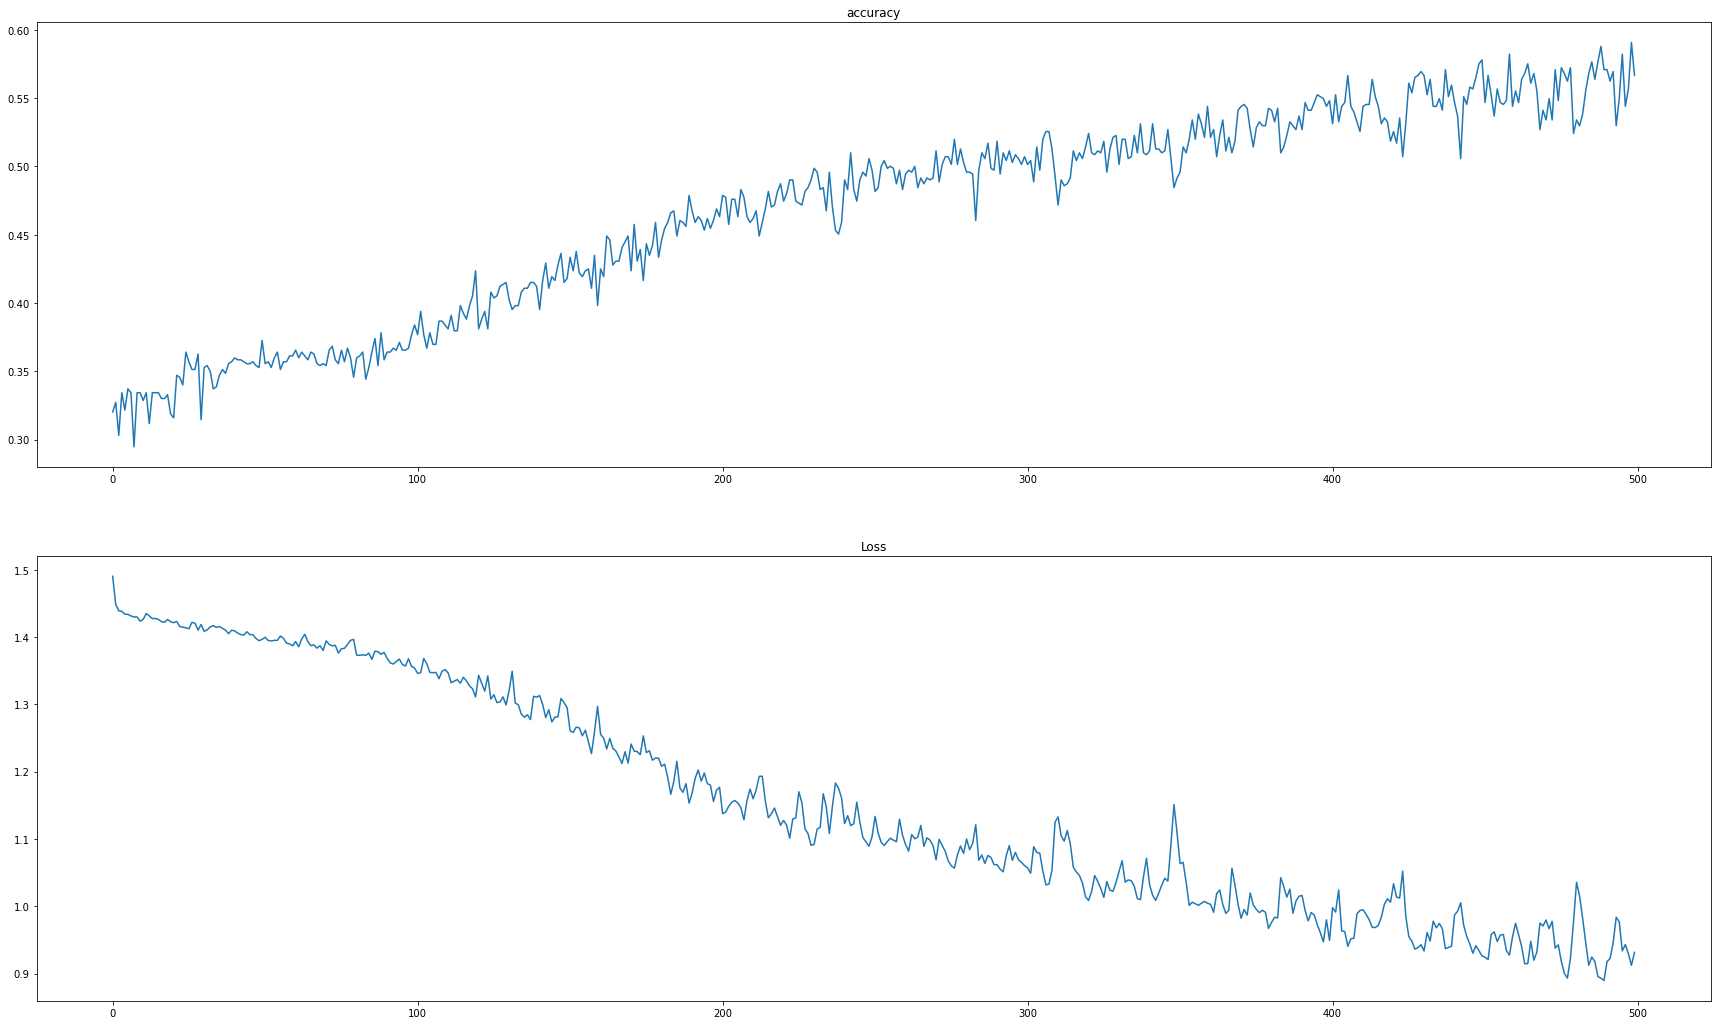

In [35]:
fig, ax = plt.subplots(2, 1)
fig.set_figwidth(30)
fig.set_figheight(18)

ax[0].plot(history.history['accuracy'])
ax[0].set_title(("accuracy"))
ax[1].plot(history.history['loss'])
ax[1].set_title(("Loss"))
plt.show()


<h2 style="text-align:center;">Red Neuronal Sklearn</h2>

In [9]:
clf = MLPClassifier(solver='adam', alpha=1e-5, activation="relu", early_stopping=True,
                    learning_rate="adaptive", hidden_layer_sizes=(3000, 200), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.32142857142857145 
El score en el test fue:  0.2755102040816326


In [10]:
clf = MLPClassifier(solver='adam', alpha=1e-5, activation="relu",
                    hidden_layer_sizes=(3000, 200), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.6275510204081632 
El score en el test fue:  0.25510204081632654


In [11]:
clf = MLPClassifier(solver='adam', alpha=1e-5, activation="relu",
                    hidden_layer_sizes=(30000, 200), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.25510204081632654 
El score en el test fue:  0.14285714285714285


In [12]:
clf = MLPClassifier(solver='adam', alpha=1e-5, activation="relu",
                    hidden_layer_sizes=(50000, 2000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.6836734693877551 
El score en el test fue:  0.25510204081632654


In [45]:
## Por el momento este es el mejor
clf = MLPClassifier(solver='sgd', alpha=1e-5, activation="relu",
                    hidden_layer_sizes=(30, 20000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.3728813559322034 
El score en el test fue:  0.36363636363636365


In [7]:
clf = MLPClassifier(solver='sgd', alpha=1e-5, activation="relu",
                    hidden_layer_sizes=(30, 20000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.43116883116883115 
El score en el test fue:  0.39473684210526316


In [11]:
clf = MLPClassifier(solver='sgd', alpha=1e-5, activation="relu",
                    hidden_layer_sizes=(30, 20000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.3881019830028329 
El score en el test fue:  0.332378223495702


In [18]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-50, activation="relu",
                    hidden_layer_sizes=(30, 20000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.5714285714285714 
El score en el test fue:  0.25510204081632654


In [23]:
clf = MLPClassifier(solver='sgd', alpha=1e-50, activation="relu", learning_rate= "adaptive",
                    hidden_layer_sizes=(30000, 200), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.336734693877551 
El score en el test fue:  0.29591836734693877


In [24]:
clf = MLPClassifier(solver='sgd', alpha=1e-50, activation="relu", learning_rate= "adaptive",
                    hidden_layer_sizes=(3000, 200), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.336734693877551 
El score en el test fue:  0.30612244897959184


In [49]:
clf = MLPClassifier(solver='adam', alpha=1e-50, activation="tanh", early_stopping=True, validation_fraction= 0.001,
                    hidden_layer_sizes=(30, 20000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.30612244897959184 
El score en el test fue:  0.25510204081632654


In [50]:
clf = MLPClassifier(solver='sgd', alpha=1e-50, activation="tanh", early_stopping=True, validation_fraction= 0.001,
                    hidden_layer_sizes=(30, 20000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.30612244897959184 
El score en el test fue:  0.2755102040816326


In [51]:
clf = MLPClassifier(solver='sgd', activation="relu", learning_rate= "adaptive",
                    hidden_layer_sizes=(30000, 2000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.336734693877551 
El score en el test fue:  0.30612244897959184


In [24]:
clf = MLPClassifier(solver='sgd', alpha=1e-5, activation="relu",
                    hidden_layer_sizes=(3000, 2000), random_state=1)
clf.fit(X_train, y_train)

print("El score en el training fue: ", clf.score(X_train, y_train), "\nEl score en el test fue: ", clf.score(X_test, y_test))

El score en el training fue:  0.29591836734693877 
El score en el test fue:  0.3469387755102041


<h2 style="text-align:center;">Kmeans</h2>

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(features)
y_pred = kmeans.predict(features)
kmeans.score(features, y_pred)

In [17]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(features)
y_pred = kmeans.predict(features)
kmeans.score(features, y_pred)

-1011.5112867810037

<h2 style="text-align:center;">Random forest</h2>

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.30945558739255014


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.3157894736842105


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.3131868131868132


<h2 style="text-align:center;">Regresión logistica</h2>

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.32951289398280803


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.39473684210526316


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.37362637362637363


<h2 style="text-align:center;">Hierechical clustering</h2>

In [14]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5)
y_pred = cluster.fit_predict(X_train)
y_pred = cluster.fit_predict(X_test)
print(accuracy_score(y_test, y_pred))

0.16905444126074498


In [28]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5)
y_pred = cluster.fit_predict(X_train)
y_pred = cluster.fit_predict(X_test)
print(accuracy_score(y_test, y_pred))

0.15934065934065933


In [18]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5)
y_pred = cluster.fit_predict(X_train)
y_pred = cluster.fit_predict(X_test)
print(accuracy_score(y_test, y_pred))

0.18181818181818182


<h2 style="text-align:center;">Arbol de desicion</h2>

In [48]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.29292929292929293


In [15]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.30659025787965616


In [44]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.2807017543859649


<h2 style="text-align:center;">GaussianNB</h2>

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.3237822349570201


In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.4052631578947368


In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.3516483516483517


<h2 style="text-align:center;">SVM (máquinas de vectores de soporte)</h2>

In [38]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.32460732984293195


In [9]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.38421052631578945


In [17]:
from sklearn.svm import SVC

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.3037249283667622


<h2 style="text-align:center;">Gaussian Mixture Model</h2>

In [18]:
from sklearn.mixture import GaussianMixture

clf = GaussianMixture(n_components=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.15759312320916904


In [16]:
from sklearn.mixture import GaussianMixture

clf = GaussianMixture(n_components=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.24210526315789474


In [10]:
from sklearn.mixture import GaussianMixture

clf = GaussianMixture(n_components=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.23859649122807017


<h2 style="text-align:center;">Perceptron</h2>

In [19]:
from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.3209169054441261


In [11]:
from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.38421052631578945


In [24]:
from sklearn.linear_model import Perceptron

clf = Perceptron()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.34065934065934067


In [20]:
maestro

,BASE TELA,COLOR,GENERO,CATEGORIA,ESTETICA,LARGO,SILUETA,TIPO,SUBCATEGORIA,item,calificacion,calif,min
0,PUNTO,ROSADO,HOMBRE,CAMISETA,ILUSTRACIÓN EN PECHO Y ESPALDA,REGULAR,AMPLIO,MANGA CORTA,CAMISETA BOX FIT,55728,A,3,"2021_03,2"
1,PUNTO,AZUL OSCURO,HOMBRE,CAMISETA,TEXTO REPUJADO,REGULAR,AMPLIO,MANGA CORTA,CAMISETA,55725,B,4,"2021_07,5"
2,PLANO,NEGRO,HOMBRE,CAMISETA,TEXTO Y NÚMEROS CON APLIQUE,OVER,AMPLIO,MANGA CORTA,CAMISETA OVERSIZE,55699,B,4,"2021_05,3"
3,PUNTO,ROJO,HOMBRE,CAMISETA,TEXTO REPUJADO,REGULAR,AMPLIO,MANGA CORTA,CAMISETA,55700,A,3,"2021_01,2"
4,PUNTO,NEGRO,HOMBRE,CAMISETA,BÁSICO,REGULAR,AMPLIO,MANGA CORTA,CAMISETA BOX FIT,60127,A,3,"2021_04,5"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1573,PUNTO,ROJO,HOMBRE,CAMISETA,TEXTO,REGULAR,AMPLIO,MANGA CORTA,CAMISETA OVERSIZE,62650,AAA,2,"2021_11,4"
1576,PUNTO,ROSADO,HOMBRE,CAMISETA,ILUSTRACIÓN,REGULAR,AMPLIO,NO APLICA,CAMISETA BOX FIT,55735,B-,5,"2021_01,4"
1577,PUNTO,NEGRO,HOMBRE,CAMISETA,BÁSICO,REGULAR,AMPLIO,NO APLICA,CAMISETA BOX FIT,55752,B,4,"2021_09,2"
1579,PUNTO,MARFIL,HOMBRE,CAMISETA,ILUSTRACIÓN,OVER,AMPLIO,MANGA CORTA,CAMISETA EN BURDA OVERSIZE,63496,AAA+,1,"2022_04,2"
